# Precautionary Saving and Precautionary Wealth

### A notebook by [Mateo Velasquez-Giraldo](https://github.com/Mv77/)

This notebook reproduces the figures in Christopher D. Carroll and Miles S. Kimball's entry on [Precautionary Saving and Precautionary Wealth](http://www.econ2.jhu.edu/people/ccarroll/PalgravePrecautionary.pdf) in [The New Palgrave Dictionary of Economics](https://www.palgrave.com/gp/book/9781349951888), using tools from the [Econ-ARK](https://econ-ark.org/) project.

In [1]:
# Setup
from HARK.ConsumptionSaving.ConsIndShockModel import IndShockConsumerType

import matplotlib.pyplot as plt
import numpy as np
mystr = lambda number : "{:.4f}".format(number)

from copy import copy

from scipy.interpolate import interp1d
from scipy.optimize import root_scalar

In [2]:
# Define parameters for two consumers,
# a perfect foresight one and one with shocks to income

# Import standard parameters
from HARK.ConsumptionSaving.ConsumerParameters import init_idiosyncratic_shocks
IdiosyncDict = init_idiosyncratic_shocks

# Make modifications to fit our problem:

# No artificial borrowing constraint
IdiosyncDict["BoroCnstArt"] = -500
# No unemployment
IdiosyncDict["UnempPrb"] = 0
# Ask HARK to compute the value function
IdiosyncDict["vFuncBool"] = True


# Create a copy with income uncertainty turned off
PFDict = copy(IdiosyncDict)
PFDict["PermShkStd"] = [0]
PFDict["TranShkStd"] = [0]

In [3]:
# Create and solve consumers
IndShockConsumer = IndShockConsumerType(**IdiosyncDict)
IndShockConsumer.cycles = 0 # Make this type have an infinite horizon
IndShockConsumer.solve()

PFConsumer = IndShockConsumerType(**PFDict)
PFConsumer.cycles = 0
PFConsumer.solve()

## Figure 1: Marginal Utility of Assets and Consumption

Consider an agent facing the following dynamic problem expressed in recursive form:

\begin{equation}
\begin{split}
v_t(m_t) =& \max_{c_t} \{u(c_t) + \beta \mathbb{E}_t[v_{t+1}(R a_t + \tilde{y}_{t+1})] \}\\
& s.t \quad a_t = m_t - c_t,
\end{split}
\end{equation}

where $c_t$ represents consumption, $m_t$ beginning-of-period resources, $a_t$ end-of-period resources, and $\tilde{y}_{t+1}$ non-capital income in the next period, which is random from the perspective of this period.

The consumer chooses $c_t$ balancing two forces:
- The desire to consume his resources now, captured by $u(c_t)$.
- The benefit that he gets from saving his resources for next period, which we represent with $\omega(a_t)=\beta \mathbb{E}_t[v_{t+1}(R a_t + \tilde{y}_{t+1})]$.

Under standard assumptions, a requirement for optimality is that $$u'(m_t - a_t) = \omega'(a_t).$$

Figure 1 shows that uncertainty shifts up the expected marginal value of
resources on the next period, moving savings from $a^*$ (which would be
observed if income were certain at $\mathbb{E}_t[\tilde{y}_{t+1}]$) to 
$a^{**}$. This increase is the precautionary saving induced by the uncertainty 
around income.

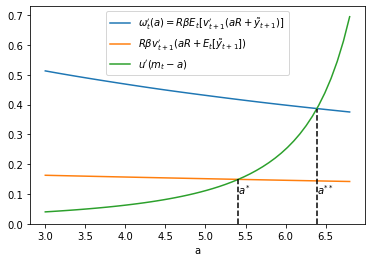

In [4]:
# Figure 1

def uP(agent, c):
    '''
    Computes the marginal utility of consumption for an agent with
    CRRA utility at a consumption level c.
    '''
    return( c**(-agent.CRRA) )
    
def approxOmegaP(agent):
    '''
    Constructs a function that computes the discounted expected marginal value
    of wealth next period w'(a) for a grid of end of period assets using the
    fact that optimal consumption c() satisfies u'(c(m_t)) = w'_t(m_t - c(m_t))
    '''
    # Take the end-of-period assets grid from the consumer
    agrid = agent.aXtraGrid
    a_min = agrid[0]
    a_max = agrid[-1]
    # For each a, we need to find the implied m that generates it
    aux = lambda m: m - agent.solution[0].cFunc(m)
    m_grid = np.array([root_scalar(lambda m: a - aux(m), x0 = a_min, x1 = a_max).root
                       for a in agrid])
    
    # Then we can get consumption
    c_grid = agent.solution[0].cFunc(m_grid)
    # And with consmption, omega, since
    # omega prime is U' at the optimal C.
    omegaP_grid = uP(agent, c_grid)
    
    # We finally interpolate
    omegaP = interp1d(agrid, omegaP_grid, kind='cubic')
    
    return(omegaP)


m = 8
a_min = 3
a_grid = np.linspace(a_min, m*0.85, 50)

# Approximate omega with and without uncertainty
omegaP_uncert = approxOmegaP(IndShockConsumer)
omegaP_PF = approxOmegaP(PFConsumer)

# Find intercepts with marginal utility
a_star1 = root_scalar(lambda a: omegaP_PF(a) - uP(PFConsumer, m - a),
                      bracket = [a_min, m-0.01]).root
a_star2 = root_scalar(lambda a: omegaP_uncert(a) - uP(IndShockConsumer, m - a),
                      bracket = [a_min, m-0.01]).root
                      
# Line labels
lab1 = '$\omega_t\'(a) = R \\beta E_t [v_{t+1}\'(aR + \\tilde{y}_{t+1})]$'
lab2 = '$R \\beta v_{t+1}\'(aR + E_t[\\tilde{y}_{t+1}])$'
lab3 = '$u\'(m_t-a)$'

# Main lines

# Omega uncertainty
plt.figure()
plt.plot(a_grid, omegaP_uncert(a_grid), label = lab1)
# Omega Perfect foresight
plt.plot(a_grid, omegaP_PF(a_grid), label = lab2)
# Marginal utility
plt.plot(a_grid, uP(IndShockConsumer, m - a_grid), label = lab3)

# Intersection lines
plt.plot([a_star1,a_star1],[0,uP(PFConsumer, m - a_star1)],'k--')
plt.text(a_star1,0.1, '$a^*$')
plt.plot([a_star2,a_star2],[0,uP(IndShockConsumer, m - a_star2)],'k--')
plt.text(a_star2,0.1, '$a^{**}$')

plt.ylim(bottom = 0)
plt.xlabel('a')
plt.legend()

## Figure 2

Figure 2 compares optimal consumption with and without income uncertainty.
The three most important facts to note are:
1. Consumption under uncertainty is always lower than its perfect-foresight counterpart.
2. The difference between them vanishes as market resources approach infinity.
3. Under uncertain future income, the consumption function is concave.

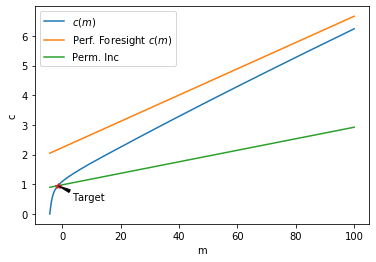

In [5]:
# Figure 2

# Define a function for the delta(m)=0 locus
m0_locus = lambda m: m - (m-1)/(IdiosyncDict["Rfree"]/
                         IdiosyncDict["PermGroFac"][0])

# Define grid of market resources
m_max = 100
m_grid = np.linspace(IndShockConsumer.solution[0].mNrmMin, m_max, 500)

# Main lines

# Uncertainty solution
plt.figure()
plt.plot(m_grid, IndShockConsumer.solution[0].cFunc(m_grid),
         label = '$c(m)$')
# Perfect foresight solution
plt.plot(m_grid, PFConsumer.solution[0].cFunc(m_grid),
         label = 'Perf. Foresight $c(m)$')
# Stable resource line
plt.plot(m_grid, m0_locus(m_grid), label = 'Perm. Inc')
# Target
targ = (IndShockConsumer.solution[0].mNrmSS,
        IndShockConsumer.solution[0].cFunc(IndShockConsumer.solution[0].mNrmSS))
plt.plot(targ[0], targ[1], '*')

# Annotations
plt.xlabel('m')
plt.ylabel('c')
plt.annotate('Target',
             xy = targ,
             xytext = (targ[0]+5, targ[1]-0.5),
             arrowprops=dict(facecolor='black', shrink=0.05,
                             headwidth = 3, width = 0.5))
plt.legend()